# Workplace Diversity Analysis
## Goal
Diversity, unconscious bias in the workplace and, in general, the way companies treat their employees are a very important topic.
Data science can help discover potential discriminations by looking at the data and see if there are segments of employees that are treated worse.
## Challenge Description
There has been lots of talking about diversity in the workplace, especially in technology. The Head of HR at your company is very concerned about that and has asked you to analyze internal data about employees and see whether results suggest that the company is treating all its employees fairly or not.

Specifically, she gave you the following tasks:
- In the company there are 6 levels (described below). Identify, for each employee, her corresponding level.
 - Individual Contributors(IC) - they don’t manage anyone
 - Middle Managers(MM) - they are the direct bosses of IC
 - Directors(D) - they are the direct bosses of MM
 - VP - D direct bosses
 - Executives (E) - VP direct bosses
 - CEO - The direct boss of E.
- How many people each employee manages? Consider that if John directly manages 2 people and these two people manage 5 people each, then we conclude that John manages 12 people.
- Build a model to predict the salary of each employee.
- Describe the main factors impacting employee salaries. Do you think the company has been treating all its employees fairly? What are the next steps you would suggest to the Head of HR?

PS: you can assume the data for this challenge is clean(e.g. no types, no mismatch when performing joins)

# 0. Load dependencies and data

In [1]:
import pandas as pd
import numpy as np
from read_data import df1, df2

import matplotlib.pyplot as plt
import seaborn as sns
from pdpbox import pdp, info_plots

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

In [2]:
df1.head()

,employee_id,boss_id,dept
0,46456,175361,sales
1,104708,29733,HR
2,120853,41991,sales
3,142630,171266,HR
4,72711,198240,sales


In [3]:
df2.head()

,employee_id,signing_bonus,salary,degree_level,sex,yrs_experience
0,138719,0,273000.0,Master,M,2
1,3192,0,301000.0,Bachelor,F,1
2,114657,0,261000.0,Master,F,2
3,29039,0,86000.0,High_School,F,4
4,118607,0,126000.0,Bachelor,F,3


In [4]:
# Join the two tables together
df = pd.merge(df1, df2, left_on='employee_id', right_on='employee_id', how='left')
df.head()

,employee_id,boss_id,dept,signing_bonus,salary,degree_level,sex,yrs_experience
0,46456,175361,sales,0,213000.0,Bachelor,M,5
1,104708,29733,HR,0,79000.0,Bachelor,F,3
2,120853,41991,sales,0,199000.0,High_School,M,5
3,142630,171266,HR,0,143000.0,PhD,F,13
4,72711,198240,sales,0,235000.0,Master,M,1


# 1. EDA
- No nulls except that CEO does not have a boss

In [5]:
# Size of data
print('Size of Data:', df.shape)
print('')

# Null and unique values
summary = pd.DataFrame({'Column Types': df.dtypes,
                        'Number of Nulls': df.isna().sum(),
                        'Unique Values': df.nunique()})
print(summary)

Size of Data: (10000, 8)

               Column Types  Number of Nulls  Unique Values
employee_id          object                0          10000
boss_id              object                1            999
dept                 object                0              5
signing_bonus         int64                0              2
salary              float64                0            344
degree_level         object                0              4
sex                  object                0              2
yrs_experience        int64                0             31


## Q1. In the company there are 6 levels (described below). Identify, for each employee, her corresponding level.
- Individual Contributors(IC) - they don’t manage anyone
- Middle Managers(MM) - they are the direct bosses of IC
- Directors(D) - they are the direct bosses of MM
- VP - D direct bosses
- Executives (E) - VP direct bosses
- CEO - The direct boss of E.

Here, we can go from top to bottom. Find the CEO first, and his direct reports(Executives), and the direct reports of
Executives(Vice Presidents), etc.

In [6]:
# Find the ID of the CEO
ceo_id = df[df['boss_id'].isnull()]['employee_id']
current_level_id = ceo_id

# Hierarchy List
hierarchy = ['CEO', 'E', 'VP', 'D', 'MM', 'IC']

# Initialize the column level
df['level'] = 'None'

# Go over the hierarchy from top to bottom
for h in hierarchy:
    # Update the level
    df['level'][df['employee_id'].isin(current_level_id)] = h
    # Find their subordinates
    current_level_id = df[df['boss_id'].isin(current_level_id)]['employee_id']

In [7]:
df.head()

,employee_id,boss_id,dept,signing_bonus,salary,degree_level,sex,yrs_experience,level
0,46456,175361,sales,0,213000.0,Bachelor,M,5,IC
1,104708,29733,HR,0,79000.0,Bachelor,F,3,IC
2,120853,41991,sales,0,199000.0,High_School,M,5,IC
3,142630,171266,HR,0,143000.0,PhD,F,13,MM
4,72711,198240,sales,0,235000.0,Master,M,1,IC


In [8]:
# Hierarchy Structure
df['level'].value_counts()

IC     9000
MM      800
D       160
VP       35
E         4
CEO       1
Name: level, dtype: int64

## Q2. How many people each employee manages?
Consider that if John directly manages 2 people and these two people manage 5 people each, then we conclude that John manages 12 people.

Here, we can go from bottom to top. Find how many staff Middle Managers mange, and how many staff Directors manage, etc.

In [9]:
# Initialize the staff column
df['num_staff'] = 0

# Go over the hierarchy from bottom to top
for h in hierarchy[::-1]:
    # Get the id of the current level employees
    current_level_id = df[df['level'] == h]['employee_id']

    # Get the number of staff each person manages
    df_staff_count = df[df['boss_id'].isin(current_level_id)]
    # len(x) is the number of their direct reports, and sum(x) is the number of subordinates of their direct reports
    df_staff_count = df_staff_count.groupby('boss_id')['num_staff'].apply(lambda x:len(x) + sum(x))
    df['num_staff'] = np.where(df['employee_id'].isin(current_level_id),
                               df['employee_id'].map(df_staff_count).fillna(0),
                               df['num_staff'])

# Convert the data type to int
df['num_staff'] = df['num_staff'].astype(int)

In [10]:
# Employees at the top of the hierarchy
df.sort_values('num_staff', ascending=False).head()

,employee_id,boss_id,dept,signing_bonus,salary,degree_level,sex,yrs_experience,level,num_staff
2427,61554,NaN,CEO,1,700000.0,PhD,M,7,CEO,9999
1310,11277,61554,sales,1,550000.0,Master,M,22,E,3598
2778,51535,61554,engineering,1,650000.0,PhD,M,33,E,2695
1009,110464,61554,marketing,1,550000.0,Master,M,21,E,2009
9640,93708,61554,HR,1,500000.0,PhD,F,28,E,1693


In [11]:
# Hierarchy Structure
df.groupby('level').mean().sort_values('num_staff', ascending=False)

,signing_bonus,salary,yrs_experience,num_staff
level,,,,
CEO,1.000000,700000.000000,7.000000,9999.000000
E,1.000000,562500.000000,26.000000,2498.750000
VP,0.400000,258028.571429,20.657143,284.571429
D,0.325000,212343.750000,14.043750,61.250000
MM,0.331250,192473.750000,7.790000,11.250000
IC,0.297556,187909.222222,3.271000,0.000000


Just out of curiosity, let's compare how much money goes to the top and the bottom of the hierarchy.

Apparently the top 20% earners take 30% of the total salaries, which seems reasonable and not as staggering as many other
companies out there in the world.

Text(0.5, 1.0, 'Lorenz Curve')

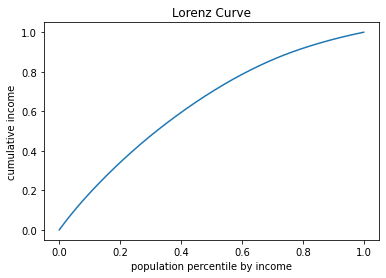

In [12]:
# Plot the lorenz curve
data_lorenz = df[['salary']].sort_values('salary', ascending=False)
data_lorenz['cumulative income'] = data_lorenz['salary'].cumsum()/data_lorenz['salary'].sum()
data_lorenz['population percentile by income'] = (data_lorenz['salary']>0).cumsum()/data_lorenz['salary'].count()

sns.lineplot(data=data_lorenz,
             x='population percentile by income',
             y='cumulative income').set_title('Lorenz Curve')

## Q3. Build a model to predict the salary of each employee
Most of the variables in this dataset are likely correlated.
For instance, level in the company is likely correlated with number of reports or years of experience.

Instead of hand-engineering independent features, we can use a Random Forest Regressor, which
is quite robust to feature correlation and works quite well out of the box in most cases.

### 3.1 Prepare training data

In [13]:
# Replace ordered categorical variables with numbers
degree2code = {'High_School':1, 'Bachelor':2, 'Master':3, 'PhD':4}
df['degree_level'] = df['degree_level'].map(degree2code)

level2code = {'IC':1, 'MM':2, 'D':3, 'VP':4, 'E':5, 'CEO':6}
df['level'] = df['level'].map(level2code)

# Make dummy variables (department)
df_dummies = pd.get_dummies(df.drop(['employee_id', 'boss_id'], axis=1), drop_first=True)

# Make X and y
X = df_dummies.drop(['salary'], axis=1)
y = df_dummies['salary']

# Split training and test data
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

### 3.2 Modeling

In [14]:
model = RandomForestRegressor(n_estimators=100,
                              n_jobs=-1,
                              oob_score=True)
model.fit(x_train, y_train)

RandomForestRegressor(n_jobs=-1, oob_score=True)

### 3.3 Validation
- Essentially, although our model is not overfitting, the prediction is on average 50k off the truth,
and around 45% of the times within the 20% range of the actual salary.

In [15]:
# Mean absolute error
print('Training MAE(OOB):', (mean_absolute_error(model.oob_prediction_, y_train)).round())
print('Test MAE:', (mean_absolute_error(model.predict(x_test), y_test)).round())

# Let's define as accuracy predictions within 20% of the actual salaries,
# since high earners tend to diverge more from the peer average in absolute terms
# Btw, to facilitate comparision, I assume a dummy model always returns the mean salary
print('Dummy Model Accuracy within 20% of Actual Salaries:', ((y_train.mean()/y_train-1).abs()<.2).mean())
print('Training Accuracy within 20% of Actual Salaries:', ((model.predict(x_train)/y_train-1).abs()<.2).mean())
print('Validation Accuracy within 20% of Actual Salaries:', ((model.predict(x_test)/y_test-1).abs()<.2).mean())

Training MAE(OOB): 58159.0
Test MAE: 58502.0
Dummy Model Accuracy within 20% of Actual Salaries: 0.276125
Training Accuracy within 20% of Actual Salaries: 0.4785
Validation Accuracy within 20% of Actual Salaries: 0.4145


## 5. Describe the main factors impacting employee salaries. Do you think the company has been treating all its employees fairly? What are the next steps you would suggest to the Head of HR?
- Years of experience, department, levels and number of staff managed appear to be the most importance factors
- Sex does not appear to matter when it comes to salaries by itself. However, males make up the majority of the high paying departments,
which drives male's average salary much higher. Likewise, they are also more likely to be promoted to middle level or high level managers,
who also have a better pay.
- Staff aren't rewarded by their experience until they have at least 15 years of experience, which may result in the poor retention rate among mid-level people.
- Surprisingly, degree almost does not matter at all.
- Action: have a more balanced gender proportion across each department; and have a more linear growth in salary as seniority goes up.


Text(0.5, 1.0, 'Feature Importnace Plot')

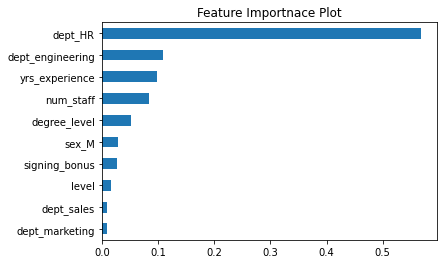

In [16]:
# Feature Importance Plot
feat_importance = pd.Series(model.feature_importances_, index=X.columns).nlargest(20)
ax = feat_importance.sort_values().plot(kind='barh')
ax.set_title('Feature Importnace Plot')

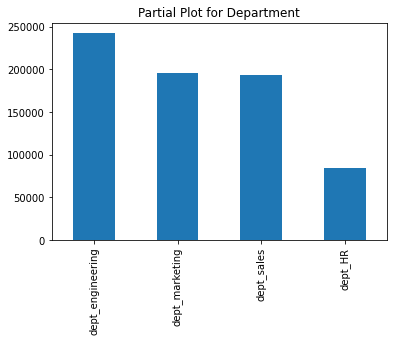

In [17]:
#PDP Plot
pdp_iso = pdp.pdp_isolate(model=model,
                          dataset=x_train,
                          model_features=x_train.columns,
                          feature=['dept_HR', 'dept_engineering', 'dept_marketing', 'dept_sales'],
                          num_grid_points=50)
pdp_dataset = pd.Series(pdp_iso.pdp, index=pdp_iso.display_columns)
pdp_dataset.sort_values(ascending=False).plot(kind='bar', title='Partial Plot for Department')
plt.show()

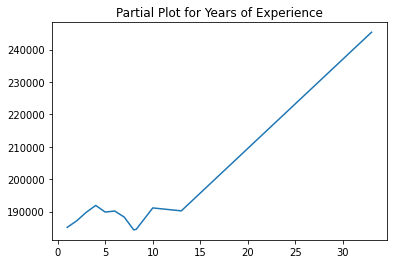

In [26]:
pdp_iso = pdp.pdp_isolate(model=model,
                          dataset=x_train,
                          model_features=x_train.columns,
                          feature='yrs_experience',
                          num_grid_points=50)
pdp_dataset = pd.Series(pdp_iso.pdp, index=pdp_iso.feature_grids)
pdp_dataset.plot(title='Partial Plot for Years of Experience')
plt.show()

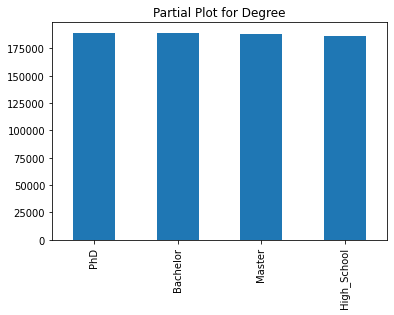

In [19]:
pdp_iso = pdp.pdp_isolate(model=model,
                          dataset=x_train,
                          model_features=x_train.columns,
                          feature='degree_level',
                          num_grid_points=50)

code2degree = {value:key for key, value in degree2code.items()}
index = [code2degree[int(code)] for code in pdp_iso.feature_grids]

pdp_dataset = pd.Series(pdp_iso.pdp, index=index)
pdp_dataset.sort_values(ascending=False).plot(kind='bar', title='Partial Plot for Degree')
plt.show()

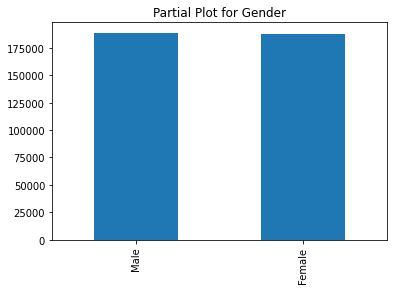

In [20]:
pdp_iso = pdp.pdp_isolate(model=model,
                          dataset=x_train,
                          model_features=x_train.columns,
                          feature='sex_M',
                          num_grid_points=50)
pdp_dataset = pd.Series(pdp_iso.pdp, index=['Female', 'Male'])
pdp_dataset.sort_values(ascending=False).plot(kind='bar', title='Partial Plot for Gender')
plt.show()

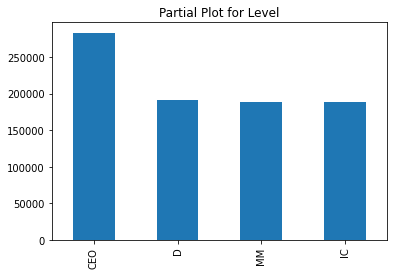

In [21]:
pdp_iso = pdp.pdp_isolate(model=model,
                          dataset=x_train,
                          model_features=x_train.columns,
                          feature='level',
                          num_grid_points=50)

code2level = {value:key for key, value in level2code.items()}
index = [code2level[int(code)] for code in pdp_iso.feature_grids]

pdp_dataset = pd.Series(pdp_iso.pdp, index=index)
pdp_dataset.sort_values(ascending=False).plot(kind='bar', title='Partial Plot for Level')
plt.show()

In [22]:
# gender equality
# avg salary males vs females
df.groupby('sex')['salary'].mean()

sex
F    171314.518394
M    198954.340736
Name: salary, dtype: float64

In [23]:
# avg salary males vs females by dept
df.groupby(['dept','sex'])['salary'].agg({'mean', 'count'})

mean  count
dept        sex                      
CEO         M    700000.000000      1
HR          F     84399.810964   1058
            M     84827.044025    636
engineering F    246785.394933    671
            M    242444.444444   2025
marketing   F    192502.304147    651
            M    195639.440765   1359
sales       F    194618.120237   1181
            M    194207.196030   2418

In [24]:
# avg salary males vs females by level
df.groupby(['level','sex'])['salary'].agg({'mean', 'count'})


mean  count
level sex                      
1     F    169473.456790   3240
      M    198279.340278   5760
2     F    182935.606061    264
      M    197171.641791    536
3     F    209085.106383     47
      M    213699.115044    113
4     F    259444.444444      9
      M    257538.461538     26
5     F    500000.000000      1
      M    583333.333333      3
6     M    700000.000000      1